In [1]:
import mindscope_utilities

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

# Measuring event triggered responses
In sensory neuroscience, we often want to ask whether a given neuron shows a consistent response to a given stimulus or behavioral event. One way to do is this is to simply calculate the average response of that neuron in a short time window surrounding the time of each repitition of a given event. These are referred to as (among other names) 'event triggered responses' or 'event triggered averages'

As an example, imagine some neuron that responds with 200 ms, perfectly stereotyped response following every presentation of some stimulus. This is obviously not biologically realistic, but is easy to implement in code for illustration purposes.

We will first define a function that generate the response given a stimulus time:

In [3]:
def generate_response(t, y, stimulus_time, response_delay=0.05, response_duration=0.2, response_amplitude=1.0):
    '''
    add a half-cosine response of a given amplitude for a given duration to a simulated neuron response
    
    Parameters:
    ----------
    t: array
        existing array of timepoints
    y: array
        existing neural response
    response_delay: float
        delay between stimulus event and response
    stimulus_time: float
        the time of a given stimulus
    response_duration: float
        the duration of the desired response (default = 0.2)
    response_amplitude: float
        the amplitude of the desired response (default = 1.0)
        
    Returns:
    --------
    numpy.array
        new neural response (y) after adding the desired response
    '''
    y = np.array(y.copy())
    
    t_start = stimulus_time + response_delay
    mask = np.where(
        np.logical_and(
            t >= t_start,
            t <= t_start + response_duration
        )
    )
    
    frequency = 1/response_duration

    y[mask] += response_amplitude/2*(1+np.cos(2*np.pi*frequency*(t[mask] - t_start - response_duration/2)))
    
    return y

Now we can create a dataframe containing the neural response and initialize it with zeros:

In [4]:
# initialize a 100 second time vector with a very fine interval (1 ms)
t = np.arange(0, 100, 0.001)

# build a dataframe with colums of 't' for time and 'response' for the neural response
response_df = pd.DataFrame({
    't': t,
    'response': np.zeros_like(t),
})
response_df.head()

,t,response
0,0.000,0.0
1,0.001,0.0
2,0.002,0.0
3,0.003,0.0
4,0.004,0.0


Then we can generate 20 random stimulus times and apply our function above to add the response at each stimulus time

In [5]:
np.random.seed(0)
stimulus_times = np.random.choice(t, size=20)

for stimulus_time in stimulus_times:
    response_df['response'] = generate_response(
        t,
        response_df['response'],
        stimulus_time = stimulus_time,
        response_delay=0.05
    )

Finally, we can plot our (highly idealized and unrealistic!) response with each stimulus time as a vertical line

In [6]:
def plot_response(response_df, stimulus_times, ax, *args, **kwargs):
    response_df.plot(
        x='t',
        y='response',
        ax=ax,
        linewidth=2,
        *args,
        **kwargs,
    )
    for stimulus_time in stimulus_times:
        ax.axvline(stimulus_time, color='k', alpha=0.25, linewidth = 1.5)
        
    ax.set_xlabel('time')
    ax.set_ylabel('response')
    

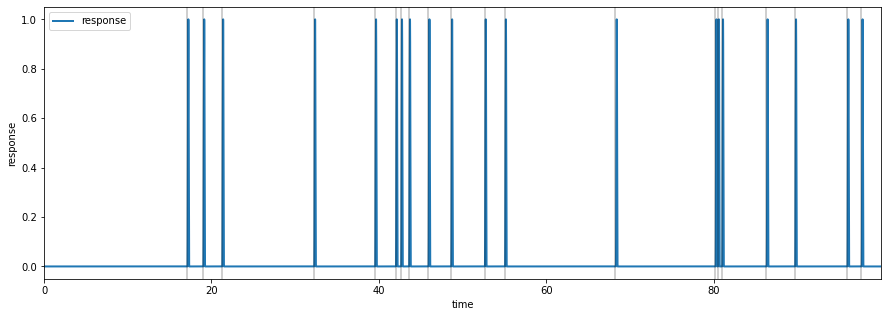

In [7]:
fig, ax = plt.subplots(figsize = (15,5))
plot_response(response_df, stimulus_times, ax)

Or, zoomed in on a small interval:

(80.0, 82.0)

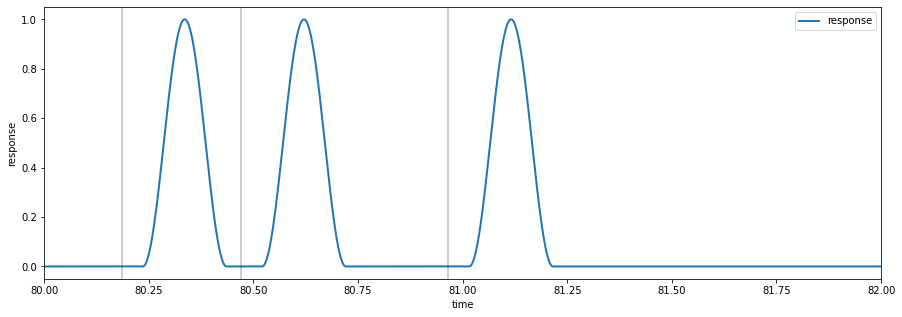

In [8]:
fig, ax = plt.subplots(figsize = (15,5))
plot_response(response_df, stimulus_times, ax)
ax.set_xlim(80, 82)

But note that we defined our stimulus and times at a very high 1000 Hz sampling rate. Two-photon imaging samples at a much lower rate. To simulate this, let's subsample our response matrix at 30 Hz:

In [9]:
def downsample(response_df, sampling_frequency):
    from scipy.interpolate import interp1d
    sample_times = np.arange(response_df['t'].min(), response_df['t'].max(), 1/sampling_frequency)
    f = interp1d(response_df['t'], response_df['response'])
    return pd.DataFrame({'t': sample_times, 'response': f(sample_times)})

In [10]:
measured_response_df = downsample(response_df, sampling_frequency=30)
measured_response_df.head()

,t,response
0,0.000000,0.0
1,0.033333,0.0
2,0.066667,0.0
3,0.100000,0.0
4,0.133333,0.0


And note that when we visualize our subsampled response, the onset times relative to the stimuli end up being somewhat variable. We'll add 'o' markers to emphasize the downsampling,

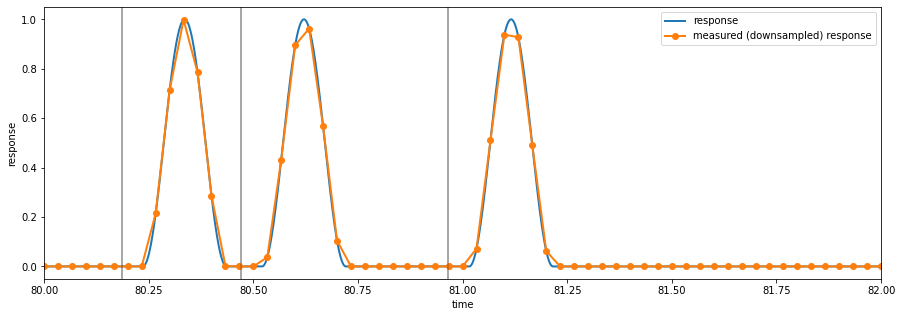

In [11]:
fig, ax = plt.subplots(figsize = (15,5))
plot_response(response_df, stimulus_times, ax)
plot_response(measured_response_df, stimulus_times, ax, marker='o')
ax.set_xlim(80, 82)
legend_text = ['actual response', 'measured (downsampled) response']
[ax.legend().get_texts()[i].set_text(text) for i, text in enumerate(legend_text)];

We can also plot each individual response relative to the stimulus time. One way to do this for 100 ms before each stimulus to 500 ms after is as follows:

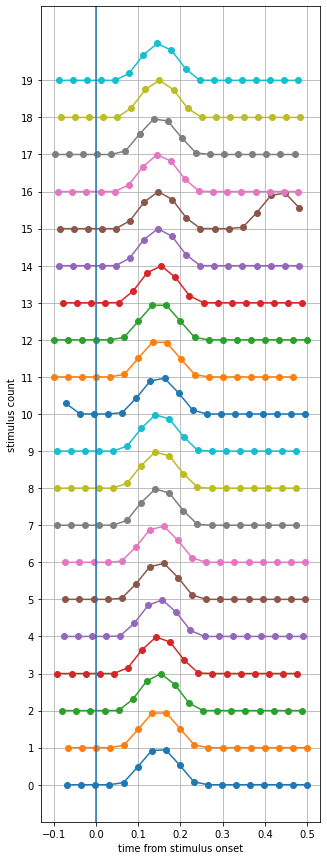

In [12]:
t_start = -0.1
t_end = 0.5
fig, ax = plt.subplots(figsize=(5,15))
for stimulus_count, stimulus_time in enumerate(stimulus_times):
    data_subset = measured_response_df.query('t >= @stimulus_time + @t_start and t <= @stimulus_time + @t_end')
    ax.plot(
        data_subset['t'] - stimulus_time,
        data_subset['response'] + stimulus_count,
        marker = 'o'
    )
ax.set_yticks(np.arange(0,20))
ax.set_ylabel('stimulus count')
ax.set_xlabel('time from stimulus onset')
ax.axvline(0)
ax.grid()

The above plot highlights two problems:
1. Due to the low sampling rate, the apparent onset time from the stimulus to the response appears variable, even though we know it is an absolute 50 ms (because we defined it that way above!)
2. Also due to the fact that the stimuli were not locked to the 30 Hz sampling rate, the sampling times relative to the stimulus times are inconsistent. This would make averaging of responses relative to the stimulus time difficult.

Issue #1 is an inherent result of low sampling rate measurements. There are (at least) two possible solutions to #2:  
* shift the responses so that the nearest acquired sample to the stimulus is aligned to the stimulus. This will result in an inaccurate measure of the response time.   
* interpolate all responses onto a higher-frequency timebase relative to the stimulus times. This won't recover information lost to the original downsampling, but it will avoid any shifting of times. 

As part of the 'mindscope_utilities' package, we have provided a function that implements the second solution. Here's how it's used:

In [13]:
etr = mindscope_utilities.event_triggered_response(
    data = measured_response_df, # the data you wish to operate on
    t = 't', # the desired time values
    y = 'response', # the desired y values
    event_times = stimulus_times, # the list or array of events
    t_start = -0.1, # desired time before each event of interest
    t_end = 0.5, # desired time after each event of interest,
    output_sampling_rate = 30, # the sampling rate on which to interpolate. 
)

Note that the `event_triggered_response` function returns a so-called 'tidy' dataframe with four columns:
* time: this is the time relative to each event on the new (in this case 30 Hz) timebase
* response: this is the response magnitude, interpolated onto the new timebase
* event_number: this is the index of each event
* event_time: These were the original event times that were passed into the function  

It's also important to note that a 'tidy' dataframe simply means that each row contains a single 'observation'. In this case, an observation is a response at a given timepoint.

In [14]:
etr

,time,response,event_number,event_time
0,-0.100000,0.000000,0,68.268
1,-0.066667,0.000000,0,68.268
2,-0.033333,0.000000,0,68.268
3,0.000000,0.000000,0,68.268
4,0.033333,0.002278,0,68.268
...,...,...,...,...
375,0.366667,0.000000,19,89.688
376,0.400000,0.000000,19,89.688
377,0.433333,0.000000,19,89.688
378,0.466667,0.000000,19,89.688


Now we can regenerate our plot from above where the interpolated version of each response is overlayed in black on the previous (non-aligned) responses.

Note that the timestamps are now aligned with one another vertically, which would allow us to average across responses.

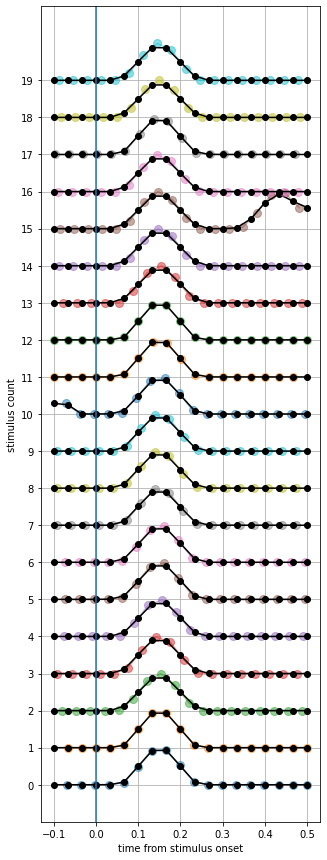

In [18]:
t_start = -0.1
t_end = 0.5
fig, ax = plt.subplots(figsize=(5,15))
for stimulus_count, stimulus_time in enumerate(stimulus_times):
    data_subset = measured_response_df.query('t >= @stimulus_time + @t_start and t <= @stimulus_time + @t_end')
    ax.plot(
        data_subset['t'] - stimulus_time,
        data_subset['response'] + stimulus_count,
        marker = 'o',
        alpha=0.5,
        markersize=8,
    )
    new_response = etr.query('event_time == {}'.format(stimulus_time))
    ax.plot(
        new_response['time'],
        new_response['response'] + stimulus_count,
        color='black',
        alpha=1,
        marker='o',
        markersize=6,
    )
ax.set_yticks(np.arange(0,20))
ax.set_ylabel('stimulus count')
ax.set_xlabel('time from stimulus onset')
ax.axvline(0)
ax.grid()

Another advantage of the 'tidy' format of the event triggered response output is that it is ideally suited for input to plotting functions in the Seaborn plotting library. For example, we can plot a lineplot with 95% bootstrapped confidence intervals with the following command.   
(https://seaborn.pydata.org/generated/seaborn.lineplot.html)

<AxesSubplot:xlabel='time', ylabel='response'>

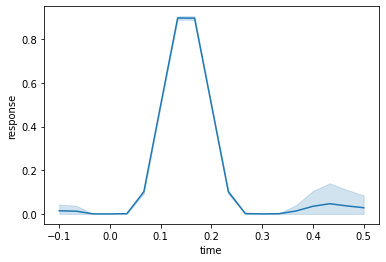

In [19]:
fig, ax = plt.subplots()
sns.lineplot(
    data = etr,
    x = 'time',
    y = 'response',
    ci = 95,
    ax = ax
)

## shift instead of interpolate
Alternately, instead of interpolating onto a common timebase, we can instead shift each response so that each is aligned.  

`mindscope_utilities.event_triggered_response` makes this possible by passing the `interpolate = False` argument

In [20]:
etr_shifted = mindscope_utilities.event_triggered_response(
    data = measured_response_df, # the data you wish to operate on
    t = 't', # the desired time values
    y = 'response', # the desired y values
    event_times = stimulus_times, # the list or array of events
    t_start = -0.1, # desired time before each event of interest
    t_end = 0.5, # desired time after each event of interest,
    interpolate = False,
    output_format = 'tidy'
)

In [21]:
etr_shifted

,time,response,event_number,event_time
0,-0.100000,0.0,0,68.268
1,-0.066667,0.0,0,68.268
2,-0.033333,0.0,0,68.268
3,0.000000,0.0,0,68.268
4,0.033333,0.0,0,68.268
...,...,...,...,...
375,0.366667,0.0,19,89.688
376,0.400000,0.0,19,89.688
377,0.433333,0.0,19,89.688
378,0.466667,0.0,19,89.688


Now we can regenerate our plot from above again where the interpolated version of each response is overlayed in black on the previous (non-aligned) responses and the shifted timepoints are overlayed in red (with an x marking each datapoint)

Note that the timestamps are now aligned with one another vertically, which would allow us to average across responses.

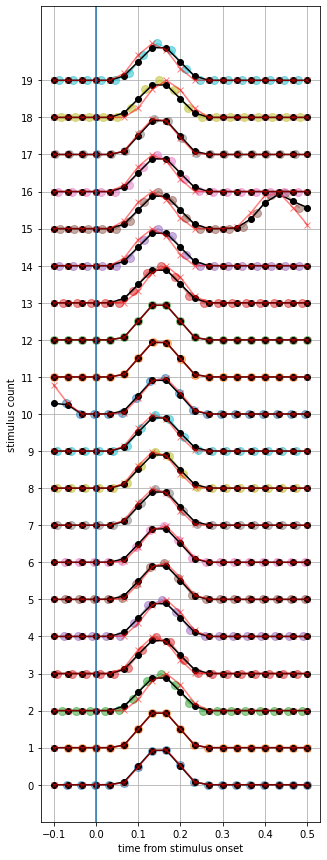

In [22]:
t_start = -0.1
t_end = 0.5
fig, ax = plt.subplots(figsize=(5,15))
for stimulus_count, stimulus_time in enumerate(stimulus_times):
    data_subset = measured_response_df.query('t >= @stimulus_time + @t_start and t <= @stimulus_time + @t_end')
    ax.plot(
        data_subset['t'] - stimulus_time,
        data_subset['response'] + stimulus_count,
        marker = 'o',
        alpha=0.5,
        markersize=8,
    )
    new_response = etr.query('event_time == {}'.format(stimulus_time))
    ax.plot(
        new_response['time'],
        new_response['response'] + stimulus_count,
        color='black',
        alpha=1,
        marker='o',
        markersize=6,
    )
    shifted_response = etr_shifted.query('event_time == {}'.format(stimulus_time))
    ax.plot(
        shifted_response['time'],
        shifted_response['response'] + stimulus_count,
        color='red',
        alpha=0.5,
        marker='x',
        markersize=6,
    )
ax.set_yticks(np.arange(0,20))
ax.set_ylabel('stimulus count')
ax.set_xlabel('time from stimulus onset')
ax.axvline(0)
ax.grid()

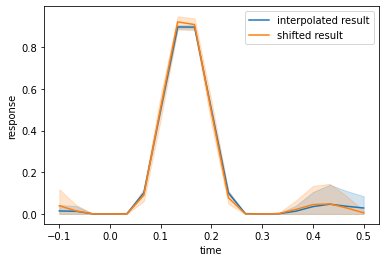

In [23]:
fig, ax = plt.subplots()
sns.lineplot(
    data = etr,
    x = 'time',
    y = 'response',
    ci = 95,
    ax = ax
)
sns.lineplot(
    data = etr_shifted,
    x = 'time',
    y = 'response',
    ci = 95,
    ax = ax
)
ax.legend(['interpolated result','shifted result'])